In [31]:
import math
from appscript import k
import mmh3
from bitarray import bitarray
import random
import matplotlib.pyplot as plt
import csv
import numpy as np

In [2]:
'Class of my BloomFilter'

class BloomFilter(object):
    def __init__(self, items_count, size):
        '''
        items_count : int   Number of items expected to be stored in bloom filter
        fp_prob : float   False Positive probability in decimal
        '''
        self.size = size
        self.hash_count = max(self.get_hash_count(self.size, items_count),1)
        self.fp_prob = self.get_fp(items_count, size, self.hash_count)   # Bit array of given size
        self.bit_array = bitarray(self.size)     # initialize all bits as 0
        self.bit_array.setall(0)

    def add(self, item):
        '''
        Add an item in the filter
        '''
        digests = []
        for i in range(self.hash_count):
            # create digest for given item.
            # i work as seed to mmh3.hash() function
            # With different seed, digest created is different
            digest = mmh3.hash(item, i) % self.size
            digests.append(digest)
            # set the bit True in bit_array
            self.bit_array[digest] = True

    def check(self, item):
        '''
        Check for existence of an item in filter
        '''
        for i in range(self.hash_count):
            digest = mmh3.hash(item, i) % self.size
            if self.bit_array[digest] == False:
                # if any of bit is False then,its not present
                # in filter
                # else there is probability that it exist
                return False
        return True

    def get_fp(self, n, m, k):
        '''
        Return the size of bit array(m) to used using
        following formula
        m = -(n * lg(p)) / (lg(2)^2)
        n : int    number of items expected to be stored in filter
        p : float   False Positive probability in decimal
        '''
        p = math.pow((1-math.exp(-k*n/m)),k)
        return float(p)
    
    def get_hash_count(self, m, n):
        """
        m is the size of the bloom filter 
        n is the number of items
        """
        k = (m/n)*math.log(2)
        return round(k)


In [42]:
'generate a bloom filter of one person SNP'

def generate_bloom(in_path, out_path, b_size):
    in_file = open(in_path, 'r')
    lines = in_file.readlines()
    n = len(lines)
    filter = BloomFilter(n,b_size)
    for line in lines:
        filter.add(line)
    out_file = open(out_path, "w")
    write_str = ''
    for bit in filter.bit_array:
        if bit==True:
            write_str += '1'
        else:
            write_str += '0'
    out_file.write(write_str)
    return (filter.hash_count)
    
### test the code
s = 1000000 
generate_bloom('chr22_person/chr22_0_A.txt', 'chr22_0_A_bloom.txt', s)
#generate_bloom('chr6-3.txt', 'chr6-3_bloom.txt', s)

12

In [22]:
'estimate the item numbers in the bloomfilter using Cardinality Estimation'

def card_check(b, m, X):
    F = math.log(1-X/b) / (m*math.log(1-1/b))
    return F

def check_BF_num(file1, file2, b, m):
    '''
    This function estimates the number of elements of one operation on two bloom filter in file1 and 2
    return the estimated number of union and each snp numbers 
    '''
    file1 = open(file1)
    l1 = file1.readlines()
    file2 = open(file2)
    l2 = file2.readlines()
    X = 0    # 1s in union
    X1 = 0   # 1s in bloom1 
    X2 = 0   # 1s in bloom2
    for i in range(b):
        if l1[0][i] == '1':
            X1 += 1
        if l2[0][i] == '1':
            X2 += 1
        if not (l1[0][i] == '0' and l2[0][i] == '0'):
            X += 1   
    return card_check(b, m, X), card_check(b, m, X1), card_check(b, m, X2)

In [23]:
'Compute the actual similarity of between snp data of two persons'

def actual_insec(file1, file2):
    '''
    The function computes the actual intersection of two snp data set
    Inputs are SNP variates of person1 and person2 
    '''
    file1 = open(file1)
    file2 = open(file2)
    l1 = file1.readlines()
    l2 = file2.readlines()
    size1 = len(l1)
    size2 = len(l2)
    i = 0
    j = 0 
    X = 0
    while i < size1 and j < size2:
        ls1 = l1[i].split('/')
        ls2 = l2[j].split('/')
        pos1 = int(ls1[1])
        pos2 = int(ls2[1])
        if pos1 == pos2:
            X += 1
            i += 1 
            j += 1 
        elif pos1 < pos2:
            i += 1
        else:
            j += 1 
    return X


In [59]:
'Keep shrinking the size of the bloom filter and compute the results'

def check_diff(file1, file2, bf1, bf2, b=1000000, w=577755):
    '''
    file1,2 are the snp vairates files of two person
    bf1,2 are the bloom filter snp files of two person
    b is the bloom filter bit array size
    m is number of hash functions
    '''
    # get v_A, v_B, which are numbers of two persons' snp variates
    file1_ = open(file1)
    file2_ = open(file2)
    l1 = file1_.readlines()
    l2 = file2_.readlines()
    v_A = len(l1)
    v_B = len(l2) 
    
    # get the actural same snp variants of two person
    insec = actual_insec(file2, file1)
    ac_union = v_A + v_B- insec
    ac_same = w-(v_A + v_B - 2*insec)
    
    # get the hash number, assume filter has optimal hash numbers
    # Two filters usually has same hash numbers
    m = max(round((b/v_A)*math.log(2)),1) 
    m_1 = (b/v_A)*math.log(2)
    
    # get the estimated samilirity of two person
    est_union, est_VA, est_VB = check_BF_num(bf1, bf2, b, m)
    est_same = w-(2*est_union - est_VA - est_VB)
    
    # cumpute the difference betweeen error and actural
    diff = abs(ac_same-est_same)/ac_same
    diff_uion = est_union-ac_union
    diff_s1 = est_VA - v_A
    diff_s2 = est_VB - v_B
    
    re = [diff, est_same, ac_same, b, m, m_1, est_union, est_VA, est_VB, ac_union, v_A, v_B ]
    
    return re

### test code
def shrink_test(snp1, snp2):
    """
    snp1 and snp2 are two input snp files
    """
    # Entropy = 
    s = 200000 # 1000000
    ss = []
    results = []
    while s >= 10000:
        re = []
        k1 = generate_bloom(snp1, 'chr22_bloom1.txt', s)
        k2 = generate_bloom(snp2, 'chr22_bloom2.txt', s)
        re = check_diff(snp1, snp2, 'chr22_bloom1.txt', 'chr22_bloom2.txt',s)
        results.append(re)
        ss.append(s)
        s = s - 2000
    return results, ss


In [110]:
folder_path = 'chr22_person/'
p1 = '121_A'
p2 = '128_B'
results, ss = shrink_test(folder_path+'chr22_' + p1 +'.txt', folder_path+'chr22_' + p2 +'.txt')

In [111]:
# Write results into a csv file with sorted error numbers
def w_csv(csv_path, results):
    res = results.copy()
    res.sort()
    with open(csv_path, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['error_rate','est_same','act_same', 'bit_size', 'hash_num','ln2*b/n',
                         'est_union','est_v1', 'est_v2', 
                         'ac_union', 'ac_v1', 'ac_v2'])
        writer.writerows(res)

In [112]:
w_csv('results_csv/chr22_' + p1 + '_' +p2 + '.csv',results)

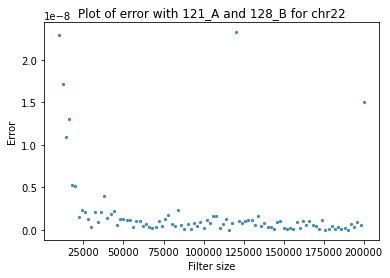

In [113]:
import numpy as np
results.sort()
results_array = np.array(results)
x = results_array[:,3]
y = results_array[:,0]/results_array[:,2]
plt.scatter(x, y, s=5, alpha=0.8)
plt.title('Plot of error with ' + p1 + ' and ' + p2 +' for chr22')
plt.xlabel('Filter size')
plt.ylabel('Error')
plt.savefig('results_fig/22_' +p1+'_'+p2 )
plt.show()